This notebook gives the convergence rate and inf-sup test of uniform prism element distribution. Note that the nodal basis is constructed from prime basis with dimension 18 given by WY2011.

In [1]:
using Plots
using LinearAlgebra
using Jacobi
using Test
using SparseArrays

# MMS
We consider following functions over a box of size $[0,a]\times[0,b]\times[0,c]$

$$ p(x,y,z) = x(a-x)y(b-y)z(c-z) $$
$$ \nabla p = \begin{bmatrix}
(a-2x)y(b-y)z(c-z) \\
x(a-x)(b-2y)z(c-z) \\
x(a-x)y(b-y)(c-2z)
\end{bmatrix} $$

For now we consider $\boldsymbol{k} = \boldsymbol{I} $, so velocity and forcing functions are
$\boldsymbol{v} = -\nabla p, \quad f = \nabla \cdot \boldsymbol{v} $. 

In [3]:
function Perm(x, y, z)
    """ permeability is consider 1 for now
    """
    k = [1. 0. 0.;0. 1. 0.;0. 0. 1.]
    return k
end

function PressureQuartic(x, y, z, a, b, c)

    p = @. x*(a-x)*y*(b-y)*z*(c-z)

    return p
end

function VelocityQuartic(x, y, z, a, b, c)

    m = length(x)
    k = Perm(x, y, z)
    vx = @. -(k[1,1]*(a-2*x)*y*(b-y)*z*(c-z) + k[1,2]*x*(a-x)*(b-2*y)*z*(c-z) + k[1,3]*x*(a-x)*y*(b-y)*(c-2*z))
    vy = @. -(k[2,1]*(a-2*x)*y*(b-y)*z*(c-z) + k[2,2]*x*(a-x)*(b-2*y)*z*(c-z) + k[2,3]*x*(a-x)*y*(b-y)*(c-2*z))
    vz = @. -(k[3,1]*(a-2*x)*y*(b-y)*z*(c-z) + k[3,2]*x*(a-x)*(b-2*y)*z*(c-z) + k[3,3]*x*(a-x)*y*(b-y)*(c-2*z))
    
    v = zeros(3,m)
    v[1,:] = vx
    v[2,:] = vy
    v[3,:] = vz
    return v
end

function ForcingQuartic(x, y, z, a, b, c)

    k = Perm(x, y, z)
    vx_x = @. -(k[1,1]*(-2)*y*(b-y)*z*(c-z) + k[1,2]*(a-2*x)*(b-2*y)*z*(c-z) + k[1,3]*(a-2*x)*y*(b-y)*(c-2*z))
    vy_y = @. -(k[2,1]*(a-2*x)*(b-2*y)*z*(c-z) + k[2,2]*x*(a-x)*(-2)*z*(c-z) + k[2,3]*x*(a-x)*(b-2*y)*(c-2*z))
    vz_z = @. -(k[3,1]*(a-2*x)*y*(b-y)*(c-2*z) + k[3,2]*x*(a-x)*(b-2*y)*(c-2*z) + k[3,3]*x*(a-x)*y*(b-y)*(-2))

    f = vx_x + vy_y + vz_z
    return f
end

ForcingQuartic (generic function with 1 method)

# Trilinear Map, Prime Basis, Normals, Nodal Basis and its divergence
We have tested these functions in PrismWY2011 notebook.

In [4]:
#============================================ Trilinear Map ==================================================#

function TrilinearMap(coord_E, xhat, yhat, zhat)
    """
    Input:
    coord_E: coordinate of element E as a 6x3 matrix
    The prism is defined by cutting a cube [-1,1]^3 on diagonal y = -x
    
    Local numbering of Prism
    
        4--------6           z
      / |                    |
    5   |                    |
    |   |                    /----y
    |   |                   /
    |   1 -------3         x
    | /
    2

    """
    
    m = length(xhat)
    N1 = @. 0.25*(-xhat-yhat)*(1-zhat)
    N2 = @. 0.25*(1+xhat)*(1-zhat)
    N3 = @. 0.25*(1+yhat)*(1-zhat)
    N4 = @. 0.25*(-xhat-yhat)*(1+zhat)
    N5 = @. 0.25*(1+xhat)*(1+zhat)
    N6 = @. 0.25*(1+yhat)*(1+zhat)
    N = [N1 N2 N3 N4 N5 N6]
    X = N * coord_E
    # X(3,m), 1st row x, 2nd row y, 3rd row z
    X = X'
    # gradient of N, [dN/dxhat; dN/dyhat; dN/dzhat]
    GradN = zeros(3,m,6)
    GradN[1,:,:] = @. 0.25*[-(1-zhat) (1-zhat) zeros(m) -(1+zhat) (1+zhat) zeros(m)]
    GradN[2,:,:] = @. 0.25*[-(1-zhat) zeros(m) (1-zhat) -(1+zhat) zeros(m) (1+zhat)]
    GradN[3,:,:] = @. 0.25*[-(-xhat-yhat) -(1+xhat) -(1+yhat) (-xhat-yhat) (1+xhat) (1+yhat)]

    # JT = [[dx/dxhat, dy/dxhat, dz/dxhat],
    #       [dx/dyhat, dy/dyhat, dz/dyhat],
    #       [dx/dzhat, dy/dzhat, dz/dzhat]] (3m x 3)

    JTxhat = GradN[1,:,:] * coord_E
    dxdxhat = JTxhat[:,1]
    dydxhat = JTxhat[:,2]
    dzdxhat = JTxhat[:,3]
    JTyhat = GradN[2,:,:] * coord_E
    dxdyhat = JTyhat[:,1]
    dydyhat = JTyhat[:,2]
    dzdyhat = JTyhat[:,3]
    JTzhat = GradN[3,:,:] * coord_E
    dxdzhat = JTzhat[:,1]
    dydzhat = JTzhat[:,2]
    dzdzhat = JTzhat[:,3]
    # compute det
    j1 = @. (dxdxhat*dydyhat*dzdzhat + dxdyhat*dydzhat*dzdzhat + dxdzhat*dydxhat*dzdyhat)
    j2 = @. (dxdxhat*dydzhat*dzdyhat + dxdyhat*dydxhat*dzdzhat + dxdzhat*dydyhat*dzdxhat)
    detJ = @. j1 - j2
    
    J = zeros(3,m,3)
    J[1,:,:] = [dxdxhat dxdyhat dxdzhat]
    J[2,:,:] = [dydxhat dydyhat dydzhat]
    J[3,:,:] = [dzdxhat dzdyhat dzdzhat]
    
    return X, J, detJ
end

#============================================ Prime Basis ==================================================#

function PrimeBasis(coord_E, xhat, yhat, zhat)

    """
    Input:
    coord_E: coordinate of physical element E as a 6x3 matrix
    xhat, yhat, zhat: are defined on the reference element Ehat
    and should be given as a vector (xhat=[1] or xhat =[1;1],...)
    
    Return:
    Prime basis: of size (3,m,18) evaluated on xhat,yhat,zhat
    Note the first entries "3", are prime basis in the directions x,y,z
    "m" are the length of xhat,yhat, zhat
    "18" is the dimension of the prime basis
    """
    m = length(xhat)
    # supplements from Wheeler, Xue, & Yotov, 2011
    shat1 = [(2*yhat .* zhat) (zeros(m)) (zeros(m))]
    shat2 = [(zeros(m)) (2*xhat .* zhat) (zeros(m))]
    shat3 = [(zeros(m)) (2*yhat .* zhat) (-zhat.^2)]  
    shat4 = [(2*xhat .* zhat) (zeros(m)) (-zhat.^2)]
    shat5 = [(xhat.^2) (xhat .* yhat) (-3*xhat .* zhat)]
    shat6 = [(yhat .* xhat) (yhat.^2) (-3*yhat .* zhat)]

    # X are in E
    X, J, detJ = TrilinearMap(coord_E, xhat, yhat, zhat)
    x = X[1,:]
    y = X[2,:]
    z = X[3,:]
    
    # we have 18 basis
    # the first 12 is defined on E using x,y,z
    P = zeros(3,m,18)
    P[1,:,1] = ones(m)
    P[1,:,2] = x
    P[1,:,3] = y
    P[1,:,4] = z
    P[2,:,5] = ones(m)
    P[2,:,6] = x
    P[2,:,7] = y
    P[2,:,8] = z
    P[3,:,9] = ones(m)
    P[3,:,10] = x
    P[3,:,11] = y
    P[3,:,12] = z
    
    # supplement are mapped to E by Piola
    P[1,:,13] = (J[1,:,1] .* shat1[:,1] + J[1,:,2] .* shat1[:,2] + J[1,:,3] .* shat1[:,3]) ./ detJ
    P[2,:,13] = (J[2,:,1] .* shat1[:,1] + J[2,:,2] .* shat1[:,2] + J[2,:,3] .* shat1[:,3]) ./ detJ
    P[3,:,13] = (J[3,:,1] .* shat1[:,1] + J[3,:,2] .* shat1[:,2] + J[3,:,3] .* shat1[:,3]) ./ detJ

    P[1,:,14] = (J[1,:,1] .* shat2[:,1] + J[1,:,2] .* shat2[:,2] + J[1,:,3] .* shat2[:,3]) ./ detJ
    P[2,:,14] = (J[2,:,1] .* shat2[:,1] + J[2,:,2] .* shat2[:,2] + J[2,:,3] .* shat2[:,3]) ./ detJ
    P[3,:,14] = (J[3,:,1] .* shat2[:,1] + J[3,:,2] .* shat2[:,2] + J[3,:,3] .* shat2[:,3]) ./ detJ

    P[1,:,15] = (J[1,:,1] .* shat3[:,1] + J[1,:,2] .* shat3[:,2] + J[1,:,3] .* shat3[:,3]) ./ detJ
    P[2,:,15] = (J[2,:,1] .* shat3[:,1] + J[2,:,2] .* shat3[:,2] + J[2,:,3] .* shat3[:,3]) ./ detJ
    P[3,:,15] = (J[3,:,1] .* shat3[:,1] + J[3,:,2] .* shat3[:,2] + J[3,:,3] .* shat3[:,3]) ./ detJ

    P[1,:,16] = (J[1,:,1] .* shat4[:,1] + J[1,:,2] .* shat4[:,2] + J[1,:,3] .* shat4[:,3]) ./ detJ
    P[2,:,16] = (J[2,:,1] .* shat4[:,1] + J[2,:,2] .* shat4[:,2] + J[2,:,3] .* shat4[:,3]) ./ detJ
    P[3,:,16] = (J[3,:,1] .* shat4[:,1] + J[3,:,2] .* shat4[:,2] + J[3,:,3] .* shat4[:,3]) ./ detJ

    P[1,:,17] = (J[1,:,1] .* shat5[:,1] + J[1,:,2] .* shat5[:,2] + J[1,:,3] .* shat5[:,3]) ./ detJ
    P[2,:,17] = (J[2,:,1] .* shat5[:,1] + J[2,:,2] .* shat5[:,2] + J[2,:,3] .* shat5[:,3]) ./ detJ
    P[3,:,17] = (J[3,:,1] .* shat5[:,1] + J[3,:,2] .* shat5[:,2] + J[3,:,3] .* shat5[:,3]) ./ detJ

    P[1,:,18] = (J[1,:,1] .* shat6[:,1] + J[1,:,2] .* shat6[:,2] + J[1,:,3] .* shat6[:,3]) ./ detJ
    P[2,:,18] = (J[2,:,1] .* shat6[:,1] + J[2,:,2] .* shat6[:,2] + J[2,:,3] .* shat6[:,3]) ./ detJ
    P[3,:,18] = (J[3,:,1] .* shat6[:,1] + J[3,:,2] .* shat6[:,2] + J[3,:,3] .* shat6[:,3]) ./ detJ
    
    return P
end

#============================================ Normals ==================================================#

function GetNormal(coord_E, xhat, yhat, zhat, face)

    """
    Input:
    coord_E: coordinate of physical element E as a 6x3 matrix
    xhat, yhat, zhat: are defined on the reference element Ehat
    and should be given as a vector (xhat=[1] or xhat =[1;1],...)
    face: that you want the normal
    
    Return: normals on physical element
    n: of size(3,m)
    le: length of n
    
    Note the face and xhat, yhat, zhat should be consistent.
    
    Based on following numbering:
    left:     nodes 1,2,4,5 at yhat = -1
    back:     nodes 1,3,4,6 at xhat = -1
    diagonal: nodes 2,3,5,6 at xhat = -yhat
    bottom:   nodes 1,2,3   at zhat = -1
    top:      nodes 4,5,6   at zhat = 1
    Local numbering of Prism
    
        4--------6           z
      / |                    |
    5   |                    |
    |   |                    /----y
    |   |                   /
    |   1 -------3         x
    | /
    2
    Since we divide a Hexa numbering are given for both case.
    And still if you call left normal gives you the normal at
    face 1,2,4,5 of the following (I know it is not left, change naming of normal later)
                5
              / |
    6-------4   |
    |       |   | 
    |       |   2
    |       | /
    3-------1
    
    """
    X, J, detJ = TrilinearMap(coord_E, xhat, yhat, zhat)

    dxdxhat = J[1,:,1]
    dxdyhat = J[1,:,2]
    dxdzhat = J[1,:,3]
    
    dydxhat = J[2,:,1]
    dydyhat = J[2,:,2]
    dydzhat = J[2,:,3]
    
    dzdxhat = J[3,:,1]
    dzdyhat = J[3,:,2]
    dzdzhat = J[3,:,3]

    m = length(xhat)
    
    if face == "left" && yhat == -ones(m)
        
        n1 = @. dydxhat*dzdzhat - dzdxhat*dydzhat
        n2 = @. dzdxhat*dxdzhat - dxdxhat*dzdzhat
        n3 = @. dxdxhat*dydzhat - dydxhat*dxdzhat
        leng = @. sqrt(n1*n1 + n2*n2 + n3*n3)
        n = zeros(3,m)
        n[1,:] = n1 ./ leng
        n[2,:] = n2 ./ leng
        n[3,:] = n3 ./ leng
      
    elseif face == "back" && xhat == -ones(m)
        
        n1 = @. dzdyhat*dydzhat - dydyhat*dzdzhat 
        n2 = @. dxdyhat*dzdzhat - dzdyhat*dxdzhat
        n3 = @. dydyhat*dxdzhat - dxdyhat*dydzhat 
        leng = @. sqrt(n1*n1 + n2*n2 + n3*n3)
        n = zeros(3,m)
        n[1,:] = n1 ./ leng
        n[2,:] = n2 ./ leng
        n[3,:] = n3 ./ leng
    
    elseif face == "diagonal" && xhat == -yhat
        #dxdshat = -dxdxhat + dxdyhat, ...
        dxdshat = J[1,:,2] - J[1,:,1]
        dydshat = J[2,:,2] - J[2,:,1]
        dzdshat = J[3,:,2] - J[3,:,1]
        
        n1 = @. dydshat*dzdzhat - dzdshat*dydzhat
        n2 = @. dzdshat*dxdzhat - dxdshat*dzdzhat
        n3 = @. dxdshat*dydzhat - dydshat*dxdzhat
        leng = @. sqrt(n1*n1 + n2*n2 + n3*n3)
        n = zeros(3,m)
        n[1,:] = n1 ./ leng
        n[2,:] = n2 ./ leng
        n[3,:] = n3 ./ leng
    
    elseif face == "top" && zhat == ones(m)
        
        n1 = @. dydxhat*dzdyhat - dzdxhat*dydyhat 
        n2 = @. dzdxhat*dxdyhat - dxdxhat*dzdyhat 
        n3 = @. dxdxhat*dydyhat - dydxhat*dxdyhat 
        leng = @. sqrt(n1*n1 + n2*n2 + n3*n3)
        n = zeros(3,m)
        n[1,:] = n1 ./ leng
        n[2,:] = n2 ./ leng
        n[3,:] = n3 ./ leng
    
    elseif face == "bottom" && zhat == -ones(m)
        
        n1 = @. dzdxhat*dydyhat - dydxhat*dzdyhat
        n2 = @. dxdxhat*dzdyhat - dzdxhat*dxdyhat
        n3 = @. dydxhat*dxdyhat - dxdxhat*dydyhat 
        leng = @. sqrt(n1*n1 + n2*n2 + n3*n3)
        n = zeros(3,m)
        n[1,:] = n1 ./ leng
        n[2,:] = n2 ./ leng
        n[3,:] = n3 ./ leng
    else
        error("face is not defined")
    end

    return n, leng
end

#============================================ Nodal Basis ==================================================#

function VondermondeMat(coord_E)
    """
    Input:
    coord_E: coordinate of physical element E as a 6x3 matrix
    
    Return:
    VM of size(18,18)
    """
    # get the normals
    nl, le = GetNormal(coord_E, [0.], [-1.],[0.],"left")
    nd, le = GetNormal(coord_E, [0.], [0.],[0.],"diagonal")
    nbt, le = GetNormal(coord_E, [-0.5], [-0.5],[-1.],"bottom")
    nt, le = GetNormal(coord_E, [-0.5], [-0.5],[1.],"top")
    nbk, le = GetNormal(coord_E, [-1.], [0.],[0.],"back")
    normals = [nbt nbt nbt nl nl nl nl nd nd nd nd nbk nbk nbk nbk nt nt nt]
    nd1 = [-1.;-1.;-1.]
    nd2 = [1.;-1.;-1.]
    nd3 = [-1.;1.;-1.]
    nd4 = [-1.;-1.;1.]
    nd5 = [1.;-1.;1.]
    nd6 = [-1.;1.;1.]
    nodes = [nd1 nd2 nd3 nd1 nd2 nd4 nd5 nd2 nd3 nd5 nd6 nd1 nd3 nd4 nd6 nd4 nd5 nd6]
    # vondermonde matrix, V_ij = phi_j(x_i).n_i
    VM = zeros(18,18)
    for i=1:18 # loop over dof
        for j=1:18 # loop over prime basis
            P = PrimeBasis(coord_E, nodes[1,i], nodes[2,i], nodes[3,i])
            VM[i,j] = P[1,1,j]*normals[1,i] + P[2,1,j]*normals[2,i] + P[3,1,j]*normals[3,i]
        end
    end

    return VM
end

function GetNodalBasis(coord_E, xhat, yhat, zhat)
   
    """
    This function returns Nodal basis as a (3,m,18) array, m = length(xhat)
    Input:
    coord_E: coordinate of physical element E as a 6x3 matrix
    xhat,yhat,zhat (vector of size m): defined on reference element Ehat
    
    Return:
    Nhat of size(3,m,18): Nodal basis for prism
    The order of these 18 nodal basis are:
    1-3:   dofs on bottom face,   nodes 1,2,3
    4-7:   dofs on left face,     nodes 1,2,4,5
    8-11:  dofs on diagonal face, nodes 2,3,5,6
    12-15: dofs on back face,     nodes 1,3,4,6
    16-18: dofs on top face,      nodes 4,5,6
    
    Local Numbering of dof for the following 
    
        4--------6           z
      / |                    |
    5   |                    |                 
    |   |                    /----y 
    |   |                   /
    |   1 -------3         x
    | /
    2   
    
    Since we divide a Hexa numbering are given for both case
                5
              / |
    6-------4   |
    |       |   | 
    |       |   2
    |       | /
    3-------1
    
    """
    
    VM = VondermondeMat(coord_E)
    P = PrimeBasis(coord_E, xhat, yhat, zhat)
    invVM = inv(VM)
    
    m = length(xhat)
    Nhat = zeros(3,m,18)
    Nhat[1,:,:] = P[1,:,:] * invVM
    Nhat[2,:,:] = P[2,:,:] * invVM
    Nhat[3,:,:] = P[3,:,:] * invVM
    
    return Nhat
end

#====================================== Divergence of Nodal Basis =============================================#

function GetDivNodalBasis(coord_E)
    """This function returns the divergence of Nodal basis as a (1,18) array
    Input:
    ------
    coord_E: coordinate of element E as 6x3 array

    Output:
    -------
    Dhat: the divergence of nodal basis computed at [xhat,yhat,zhat]
    shape (1,18)
    """
    VM = VondermondeMat(coord_E)
    # This is the divergence of prime basis 
    divV = [0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
    invVM = inv(VM)
    Dhat = divV * invVM

    return Dhat
end

GetDivNodalBasis (generic function with 1 method)

# Quadrature, Local Operators (Mass, Div, Force)

In [5]:
#========================================== Quadrature for 2D =================================================#

include("GetQuadratureTriangle.jl") # returns w, q for integration over triangle (-1,-1), (1,-1), (-1,1)
#See test integration for example. Input is Q_tri which is the number of quadrature in 2D triangle.
# No.of Q_tri in 2D for above function can be: 1, 3, 4, 6, 7, 12, 13, 16, 19, 25 
# which is accurate for polynomial degree of : 1, 2, 3, 4, 5, 6,  7,  8,  9, 10

function GetQuadrature2D(Q1d)
    """ 
    Input:
    Q1d: number of quadrature points in 1D over [-1,1]
    
    Return:Gauss Quadrature over [-1,1]^2.
    qx:
    qy:
    w2:
    """
    # 1D Gauss
    q = zgj(Q1d, 0.0, 0.0)
    w = wgj(q, 0.0, 0.0)
    
    w2 = zeros(Q*Q)
    qx = zeros(Q*Q)
    qy = zeros(Q*Q)
    for i=1:Q
        for j=1:Q
            k = (i-1)*Q +j
            qx[k] = q[j]
            qy[k] = q[i]
            w2[k] = w[j]*w[i]
        end
    end
    return w2, qx, qy
end

#========================================== Quadrature for Prism ================================================#

function GetQuadraturePrism(Q1d, Q_tri)
    """
    Input:
    Q1d: number of quadrature points in 1D over [-1,1]
    Q_tri: number of quadrature points over 2D triangle (-1,-1),(1,-1),(-1,1)
    
    Return:
    w: weight of quadrature for prism, size Q1d*Q_tri
    q: quadratue points as (3,Q1d*Q_tri) array
    """
    # 1D Gauss
    q1 = zgj(Q1d, 0.0, 0.0)
    w1 = wgj(q1, 0.0, 0.0)
    
    w2, q2 = GetQuadratureTriangle(Q_tri)
    
    Qp = Q1d*Q_tri
    w = zeros(Qp)
    for i = 1:Q1d
        for j = 1:Q_tri
            w[j + (i-1)*Q_tri] = w1[i]*w2[j]
        end
    end
    
    q = zeros(3,Qp)
    for i = 1:Q1d
        for j = 1:Q_tri
            q[1,j + (i-1)*Q_tri] = q2[j,1]
            q[2,j + (i-1)*Q_tri] = q2[j,2]
            q[3,j + (i-1)*Q_tri] = q1[i]
        end
    end
    
    return w, q
    
end

#========================================== Local Operators ================================================#

function GetLocalOperator(coord_E, Q1d, Q_tri, Forcing)
    """This function returns the interpolation of mass operator (v,kinv*u)
    divergence operator (q,div(u)) term in weak form and forcing term (q,f)
    Me = N^T*W*N (interpolation of (v,K^{-1}*u)), where
    W = diag(W1,W2,...Wq) and Wi = wi*K^{-1} where K^{-1} is inverse of permeability matrix
    Wi is 3x3 matrix. And 
    N: Nodal basis evaluated at quadrature points
    shape of N is (3,m,18), m = Q1d*Q_tri

    Input:
    ------
    coord_E: coordinate of element E as 6x3 array
    Q1d: number of quadrature points in 1D over [-1,1]
    Q_tri: number of quadrature points over 2D triangle (-1,-1),(1,-1),(-1,1)

    Output:
    -------
    Me: interpolation of (v,kinv*u) (18,18), 
    Be: interpolation of (q,div(u)) as (1,18) array
    Fpe: interpolation of (q,f) as 1x1 array 
    """
    w, q = GetQuadraturePrism(Q1d, Q_tri)
    qx = q[1,:]
    qy = q[2,:]
    qz = q[3,:]
    # total number of quadrature points, or m = length(qx)
    m = Q1d*Q_tri
    # return Nodal basis as (3,m,18) array
    Nhat = GetNodalBasis(coord_E, qx, qy, qz)
    # reshape Nhat as a (3m,18) array
    N = reshape(Nhat,3*m,:)
    # get (x,y,z) on E, detJ,...
    X, J, detJ = TrilinearMap(coord_E, qx, qy, qz)
    x = X[1,:]
    y = X[2,:]
    z = X[3,:]
    # weight, detJ and permeability
    W = zeros(3*m,3*m)
    for i=1:m
        k = Perm(x[i], y[i], z[i])
        kinv = inv(k)
        W[3*i-2:3*i, 3*i-2:3*i]=kinv*w[i]*detJ[i]
    end
    # local mass
    Me = N' * W * N
    
    
    Fp = Forcing(x, y, z)
    # Dhat and nodal basis for pressure are the same for all quadrature points
    Dhat = GetDivNodalBasis(coord_E)
    D = repeat(Dhat, inner=(m,1))
    Np = repeat([1], inner=(m,1))
    # create a diagonal matrix from weight and detJ
    w1 = w .* detJ
    WW = Diagonal(w1)

    Fpe = Np' * WW * Fp
    Be = Np' * WW * D
    
    return Me, Be, Fpe
end

GetLocalOperator (generic function with 1 method)

# Connectivity, Mesh, Assembly

In [6]:
#===================================== Connectivity of nodes and faces =========================================#

function GetConnectivity(nx, ny, nz)
    """
    This functions works for nz = 1 right now. TODO: extend for general nz!
    This function returns the connectivity array based on face and nodes
    Input:
    ------
    nx: number of hexa element in x direction
    ny: number of hexa element in y direction
    nz: number of hexa element in z direction
    we multiply nx by 2, since we cut our hexa in y=-x
    Output:
    ------
    IENf: connectivity array of size 5x(numelem) based on face numbering.
    We need IENf for assembly
    IENn: connectivity array of size 6x(numelem) based on node numbering.
    We need IENn to find the coordinate of nodes in assembly
    """
    # number of nodes in x-direction
    ndx = nx + 1
    # number of nodes in y-direction
    ndy = ny + 1
    # number of nodes in z-direction
    ndz = nz + 1
    # number of element (divide each hexa by 2 prism)
    nqx = nx # I need nqx later which is number of hexa element in x
    nx = 2*nqx
    num_elem = nx*ny*nz

    # connectivity of the nodes
    IENn = zeros(Int64,6,num_elem)
    el1 = [1;2;ndx+1;ndx*ndy+1;ndx*ndy+2;ndx*ndy+ndx+1]
    el2 = [ndx+2;ndx+1;2;ndx*ndy+ndx+2;ndx*ndy+ndx+1;ndx*ndy+2]
    for k = 1:nz
        e1 = el1 .+ (k-1)*ndx*ndy
        e2 = el2 .+ (k-1)*ndx*ndy
        for j=1:ny
            for i=1:nx
                ele = (k-1)*nx*ny + (j-1)*nx + i
                if isodd(ele)
                    IENn[:,ele] = e1
                    e1 .+= 1
                else
                    IENn[:,ele] = e2
                    e2 .+= 1
                end
            end
            e1 .+= 1
            e2 .+= 1
        end
    end

    # connectivity of the faces
    # for 1 layer of mesh in z direction number of faces
    num_face_z1 = (ndx*ny*1) + (ndy*nqx*1) + nqx*ny*1 + 2*nqx*ny*2
    IENf = zeros(Int64,5,num_elem)
    lz = nx*ny+ny*ndx+ny*nqx+nqx*ndy
    r1 = ndx+nx
    fac1 = [1;nx*ny+1;nx*ny+ndx+1;nx*ny+ndx;lz+1]
    fac2 = [2;nx*ny+1+r1;nx*ny+ndx+1;nx*ny+ndx+2;lz+2]
    fx = [2;1;2;2;2]
    fy = [0;ndx+nqx;nqx+1;nqx+1;0]
    for k = 1:nz
        f1 = fac1 .+ (k-1)*(num_face_z1 - nx*ny)
        f2 = fac2 .+ (k-1)*(num_face_z1 - nx*ny)
        for j = 1:ny
            for i=1:nqx
                ele1 = (k-1)*nx*ny + (j-1)*nx + 2*i-1
                ele2 = (k-1)*nx*ny + (j-1)*nx + 2*i
                IENf[:,ele1] = f1
                IENf[:,ele2] = f2
                f1 += fx
                f2 += fx
            end
            f1 += fy
            f2 += fy
        end
    end

    return IENf, IENn
end

#===================================== Coordinates of Nodes over [0,1]^3 =======================================#

function GetCoordNodes(nx, ny, nz, a, b, c)
    """
    This functions returns the coordinate of all nodes.
    We create a box of size [0,a]x[0,b]x[0,c] (in x,y,z directions).
    Then we mesh with nx, ny, nz elements.
    Note we dived each hexa by 2. So we have 2*nx*ny*nz prism elements
    Input:
    nx:   integer
            number of hexa elements in the x direction.
    ny:   integer
            number of hexa elements in the y direction.
    nz:   integer
            number of hexa elements in the z direction.
    
    Return:
    Coord_Ns: coordinates of nodes of a mesh as (x,y,z)
    """
    ndx = nx + 1
    ndy = ny + 1
    ndz = nz + 1
    # number of nodes in xy plane
    num_ndxy = ndx*ndy
    # total numbers of node
    num_nd = ndx*ndy*ndz
    
    meshgrid(x1, y1) = (repeat(x1, outer=length(y1)), repeat(y1, inner=length(x1)))
    x2, y2 = meshgrid(LinRange(0,a,ndx), LinRange(0,b,ndy))
    
    z2 = LinRange(0,c,ndz)
    
    x = zeros(num_nd)
    y = zeros(num_nd)
    z = zeros(num_nd)
    for i=1:ndz
        x[1 + (i-1)*num_ndxy:i*num_ndxy] = x2
        y[1 + (i-1)*num_ndxy:i*num_ndxy] = y2
        z[1 + (i-1)*num_ndxy:i*num_ndxy] = z2[i]*ones(num_ndxy)
    end
    
    Coord_Ns = zeros(3, num_nd)
    Coord_Ns[1,:] = x
    Coord_Ns[2,:] = y
    Coord_Ns[3,:] = z
    
    return Coord_Ns
    
end

#============================================ Plot Mesh =================================================#

function PlotMesh(nx, ny, nz, a, b, c)

    p = plot()
    IENf, IENn = GetConnectivity(nx, ny, nz)
    Coord_Ns = GetCoordNodes(nx, ny, nz, a, b, c)
    x = Coord_Ns[1,:]
    y = Coord_Ns[2,:]
    z = Coord_Ns[3,:]
    num_elem = 2*nx * ny * nz
    n1 = [1 2 3 1 4 5 6 4]
    n = length(n1)
    xx = zeros(n,1)
    yy = zeros(n,1)
    zz = zeros(n,1)
    xx2 = zeros(2,1)
    yy2 = zeros(2,1)
    zz2 = zeros(2,1)
    xx3 = zeros(2,1)
    yy3 = zeros(2,1)
    zz3 = zeros(2,1)
    for i =1:num_elem
        for j =1:n
        xx[j] = x[IENn[n1[j],i]] 
        yy[j] = y[IENn[n1[j],i]]
        zz[j] = z[IENn[n1[j],i]]
        end
    plot!(p,xx,yy,zz,color="black",legend=false)

    xx2[1] = x[IENn[2,i]]; xx2[2] = x[IENn[5,i]]
    yy2[1] = y[IENn[2,i]]; yy2[2] = y[IENn[5,i]]
    zz2[1] = z[IENn[2,i]]; zz2[2] = z[IENn[5,i]]
    
    xx3[1] = x[IENn[3,i]]; xx3[2] = x[IENn[6,i]]
    yy3[1] = y[IENn[3,i]]; yy3[2] = y[IENn[6,i]]
    zz3[1] = z[IENn[3,i]]; zz3[2] = z[IENn[6,i]]
    
    plot!(p,xx2,yy2,zz2,color="black",legend=false)
    plot!(p,xx3,yy3,zz3,color="black",legend=false, title = "uniform mesh distribution on [0 1]^3")
    end
    return p
end

#============================================ Dofs array =================================================#

function GetID(nx, ny, nz)
    """
    This function returns an array of global dof of size (4,num_faces)
    triangle face has 3 dof and quad face 4.
    Input:
    nx:   integer
            number of hexa elements in the x direction.
    ny:   integer
            number of hexa elements in the y direction.
    nz:   integer
            number of hexa elements in the z direction.
    
    Return:
    ID: array which contains dof numbers
    """
    ndx = nx + 1
    ndy = ny + 1
    ndz = nz + 1
    # all quad in y-z plane + all quad in x-z + all diagonal + all triangle
    num_face = (ndx*ny*nz) + (ndy*nx*nz) + nx*ny*nz + 2*nx*ny*ndz
    # number of triangle face on bottom, total triangle is ndz*num_tri
    num_tri1 = 2*nx*ny
    # number of quad faces in one layer of nz
    num_quad1 = (ndx*ny*1) + (ndy*nx*1) + nx*ny*1
    
    # dof on quad is 4 and on tri is 3
    ID = spzeros(Int64,4,num_face)
    # fill dof of bottom 
    for i=1:num_tri1
        for j=1:3
            ID[j, i] = 3*(i-1) + j
        end
    end
    
    for k = 1:nz
        d1 = maximum(ID)
        # fill dof of quads 
        for i=1:num_quad1
            for j=1:4
                ID[j,i + k*num_tri1 + (k-1)*num_quad1] = 4*(i-1) + j + d1
            end
        end
    
        d2 = maximum(ID)
        # fill dof of top for each nz
        for i=1:num_tri1
            for j=1:3
                ID[j,i + k*num_tri1 + k*num_quad1] = 3*(i-1) + j + d2
            end
        end
    end
    
    return ID
end


function GetLM(ID, IENf)
    """
    This functions is LM created based on ID and connectivity
    Input:
    ID:   ID array which contains the dof numbers
    INEf: Connectivity array of faces
    
    Return:
    LM: dof-connectivity array for assembly
    """
    num_elem = size(IENf,2)
    # local dof number
    local_dof = 18
    LM = zeros(Int64,local_dof,num_elem)
    for e=1:num_elem
        if isodd(e)
            LM[1:3, e] = ID[1:3, IENf[1,e]]
            LM[4:7, e] = ID[1:4, IENf[2,e]]
            LM[8:11, e] = ID[1:4, IENf[3,e]]
            LM[12:15, e] = ID[1:4, IENf[4,e]]
            LM[16:18, e] = ID[1:3, IENf[5,e]]
        else
            # to match the global and local numbering for even elements
            LM[1:3, e] = ID[1:3, IENf[1,e]]
            LM[4:5, e] = ID[2:-1:1, IENf[2,e]]
            LM[6:7, e] = ID[4:-1:3, IENf[2,e]]
            LM[8:9, e] = ID[2:-1:1, IENf[3,e]]
            LM[10:11, e] = ID[4:-1:3, IENf[3,e]]
            LM[12:13, e] = ID[2:-1:1, IENf[4,e]]
            LM[14:15, e] = ID[4:-1:3, IENf[4,e]]
            LM[16:18, e] = ID[1:3, IENf[5,e]]
        end

    end

    return LM
end

#========================================== Coordinate of Element ============================================#

function GetCoordElem(Coord_Ns, IENn, e)
    """
    This functions returns coordinate of element "E"
    Input:
    x,y,z: coordinate of all nodes of a mesh
    IENn: connectivity of nodes
    
    Return:
    coord_E: coordinate of element e as a (6,3) array
    """
    # get coordinate of nodes
    x = Coord_Ns[1,:]
    y = Coord_Ns[2,:]
    z = Coord_Ns[3,:]
    
    ce = IENn[:,e]
    coord_E = zeros(6,3)
    coord_E[:,1] = x[ce]
    coord_E[:,2] = y[ce]
    coord_E[:,3] = z[ce]
    
    return coord_E
end

#========================================== Global dof direction ============================================#

function GetGlobalNormal(coord_E, e)
    """
    This function returns the global dof normals.
    Note that the local dof directions are outward.
    We compare the global dof direction and
    local dof direction for assembly later
    """
    if isodd(e)
        #bottom face normal 
        a = coord_E[3,:] - coord_E[1,:]
        b = coord_E[2,:] - coord_E[1,:]
        c = cross(a,b)
        Nbt = normalize(c)
        #top face normal 
        a = coord_E[6,:] - coord_E[4,:]
        b = coord_E[5,:] - coord_E[4,:]
        c = cross(a,b)
        Nt = normalize(c)
        #left face normal
        a = coord_E[2,:] - coord_E[1,:] 
        b = coord_E[4,:] - coord_E[1,:]
        c = cross(a,b)
        Nl = normalize(c)
        #back face normal 
        a = coord_E[3,:] - coord_E[1,:]
        b = coord_E[4,:] - coord_E[1,:]
        c = cross(a,b)
        Nbk = normalize(c)
        #diagonal face normal 
        a = coord_E[3,:] - coord_E[2,:]
        b = coord_E[5,:] - coord_E[2,:]
        c = cross(a,b)
        Nd = normalize(c)
    else
        #bottom face normal 
        a = coord_E[3,:] - coord_E[1,:]
        b = coord_E[2,:] - coord_E[1,:]
        c = cross(a,b)
        Nbt = normalize(c)
        #top face normal 
        a = coord_E[6,:] - coord_E[4,:]
        b = coord_E[5,:] - coord_E[4,:]
        c = cross(a,b)
        Nt = normalize(c)
        #left face normal
        a = coord_E[4,:] - coord_E[1,:] 
        b = coord_E[2,:] - coord_E[1,:]
        c = cross(a,b)
        Nl = normalize(c)
        #back face normal 
        a = coord_E[4,:] - coord_E[1,:]
        b = coord_E[3,:] - coord_E[1,:]
        c = cross(a,b)
        Nbk = normalize(c)
        #diagonal face normal 
        a = coord_E[5,:] - coord_E[2,:]
        b = coord_E[3,:] - coord_E[2,:]
        c = cross(a,b)
        Nd = normalize(c)
    end

    return Nbt, Nl, Nd, Nbk, Nt 
end

#========================================== Element Restriction ============================================#

function GetElementRestriction(LM, coord_E, e)
    """
    This function is map between local to global dof or element restriction operator.
    We use this function to scatter the local vector or matrix
    to global vector or matrix in assembly process
    """
    global_dof = maximum(LM)
    # local dof number
    local_dof = 18
    temp = zeros(Int64,local_dof,1)
    
    # Normal of global dof
    Nbt, Nl, Nd, Nbk, Nt = GetGlobalNormal(coord_E, e)
    # normal of local dof
    nbt, le = GetNormal(coord_E, [-0.5], [-0.5],[-1.],"bottom")
    nl, le = GetNormal(coord_E, [0.], [-1.],[0.],"left")
    nd, le = GetNormal(coord_E, [0.], [0.],[0.],"diagonal")
    nbk, le = GetNormal(coord_E, [-1.], [0.],[0.],"back")
    nt, le = GetNormal(coord_E, [-0.5], [-0.5],[1.],"top")
    
    # dot of normal on face 1
    dn1 = dot(nbt,Nbt)
    # dot of normal on face 2
    dn2 = dot(nl,Nl)
    # dot of normal on face 3
    dn3 = dot(nd,Nd)
    # dot of normal on face 4
    dn4 = dot(nbk,Nbk)
    # dot of normal on face 5
    dn5 = dot(nt,Nt)
    
    Loc2Globnormal = zeros(local_dof)
    Loc2Globnormal[1:3] .= dn1
    Loc2Globnormal[4:7] .= dn2
    Loc2Globnormal[8:11] .= dn3
    Loc2Globnormal[12:15] .= dn4
    Loc2Globnormal[16:18] .= dn5
    
    temp[:,1] = LM[:,e]
    # element restriction operator
    L = spzeros(local_dof,global_dof)
    for i=1:local_dof
        if Loc2Globnormal[i] > 0
            # local dof and global dof are in same direction
            L[i, temp[i,1] ] = 1
        else
            # local dof and global dof are in opposite direction
            L[i, temp[i,1] ] = -1
        end
    end
    
    return L
end

#============================================== Shared Faces ================================================#

function GetSharedFaceDof(LM)
    """
    This function returns the global dof on shared face.
    In projection of exact vector u, in shared face, we need to divide it by 2, to avoid
    counting a vector dof twice.
    """
    num_elem = size(LM,2)
    local_dof = 18
    # get all shared edges
    sharedface1=[]
    for e1=1:num_elem
        for e2=2:num_elem
            for j=1:local_dof
                for i=1:local_dof
                    if LM[j,e1]==LM[i,e2] && e1 != e2
                        push!(sharedface1,LM[j,e1])
                    end
                end
            end
        end
    end

    # delete the possible repeated dof           
    sharedface = [] 
    for x in sharedface1
        if !(x in sharedface)
            push!(sharedface,x)
        end
    end
    # sort shared global dof
    idx = sortperm(sharedface)
    sharedface = sharedface[idx];

    return sharedface
end

#============================================== Assembly ================================================#

function Assembly(Coord_Ns, LM, IENn, Q1d, Q_tri, Forcing)
    """This function assembles M=(v,kinv*u), B=(q,div(u)) and Fp=(q,f)
    """    
    num_elem = size(LM,2)
    global_dof = maximum(LM)
    Fp = zeros(num_elem, 1)
    M = zeros(global_dof,global_dof)
    B = zeros(num_elem, global_dof)

    for e=1:num_elem
        # get element restriction operator L for element e
        coord_E = GetCoordElem(Coord_Ns, IENn, e)
        L = GetElementRestriction(LM, coord_E, e)
        Me, Be, Fpe = GetLocalOperator(coord_E, Q1d, Q_tri, Forcing)
        # assemble M
        M = M + L' * Me * L
        # assemble B
        B[e,:] = (-Be) * L
        Fp[e,:] = (-Fpe)
    end

    return M, B, Fp
end

Assembly (generic function with 1 method)

# Numerical and Exact Solution

In [7]:
#=========================================== Numerical Solution ==============================================#

function GetFESol(M, B, Fp)
    """
    This function returns the FE global u and p
    """
    global_dof = size(M,1)
    num_elem = size(B,1)
    
    P = zeros(num_elem, num_elem)
    K = [M B';B P]
    Fu = zeros(global_dof,1)
    F = [Fu;Fp]
    
    U = K \ F
    uh = zeros(global_dof,1)
    ph = zeros(num_elem,1)
    for i=1:global_dof
        uh[i] = U[i,1]
    end

    for i=1:num_elem
        ph[i] = U[global_dof+i,1]
    end

    return uh, ph
end

#============================================ Exact Solution ===============================================#

function DiscretizeUe(coord_E, uexact)
    """
    This function discretize the vector u = uexact(x,y,z) on element E
    """
    # get the normals
    nl, le = GetNormal(coord_E, [0.], [-1.],[0.],"left")
    nd, le = GetNormal(coord_E, [0.], [0.],[0.],"diagonal")
    nbt, le = GetNormal(coord_E, [-0.5], [-0.5],[-1.],"bottom")
    nt, le = GetNormal(coord_E, [-0.5], [-0.5],[1.],"top")
    nbk, le = GetNormal(coord_E, [-1.], [0.],[0.],"back")
    normals = [nbt nbt nbt nl nl nl nl nd nd nd nd nbk nbk nbk nbk nt nt nt]
    nd1 = coord_E[1,:]
    nd2 = coord_E[2,:]
    nd3 = coord_E[3,:]
    nd4 = coord_E[4,:]
    nd5 = coord_E[5,:]
    nd6 = coord_E[6,:]
    nodes = [nd1 nd2 nd3 nd1 nd2 nd4 nd5 nd2 nd3 nd5 nd6 nd1 nd3 nd4 nd6 nd4 nd5 nd6]

    x = nodes[1,:]
    y = nodes[2,:]
    z = nodes[3,:]
    uu = uexact(x,y,z)
    ue = uu[1,:] .* normals[1,:] + uu[2,:] .* normals[2,:] + uu[3,:] .* normals[3,:]
    
    return ue
end

function GetExactU(Coord_Ns, LM, IENn, uexact)
    """This function assembles discretize exact ue on a mesh
    """
    num_elem = size(IENn,2)
    global_dof = maximum(LM)
    u = zeros(global_dof, 1)

    for e=1:num_elem
        coord_E = GetCoordElem(Coord_Ns, IENn, e)
        L = GetElementRestriction(LM, coord_E, e)
        # get discretized vector u for element e
        ue = DiscretizeUe(coord_E, uexact)
        # assemble U
        u = u + L' * ue
    end

    # divide those repeated dof in shared faces by 2
    facedof = GetSharedFaceDof(LM)
    for i=1:length(facedof)
        u[facedof[i],1] = u[facedof[i],1]/2
    end
    
    return u
end

function GetExactP(Coord_Ns, IENn, pexact)
    """
    This function returns the global exact p
    """

    num_elem = size(IENn,2)
    p = zeros(num_elem,1)
    # Find centroid of each element and compute exact pressure there
    for e = 1:num_elem
        coord_E = GetCoordElem(Coord_Ns, IENn, e)
        x1 = coord_E[1,1]
        x2 = coord_E[2,1]
        x3 = coord_E[3,1]
        y1 = coord_E[1,2]
        y2 = coord_E[2,2]
        y3 = coord_E[3,2]
        z1 = coord_E[1,3]
        z4 = coord_E[4,3]
        xp = (x3+x2+x1)/3
        yp = (y3+y2+y1)/3
        zp = (z4+z1)/2
        
        pe = pexact(xp, yp, zp)
        p[e] = pe
    end

    return p
end

GetExactP (generic function with 1 method)

# Convergence rate

In [8]:
N = 6
eu = zeros(N-1)
ep = zeros(N-1)
H = zeros(N-1)
# size of box [0,a]x[0,b]x[0,c]
a = 1
b = 1
c = 0.0001
# quadrature
Q1d = 4
Q_tri = 19
# exact solution
uexact(x,y,z) = VelocityQuartic(x, y, z, a, b, c)
pexact(x,y,z) = PressureQuartic(x, y, z, a, b, c)
Forcing(x,y,z) = ForcingQuartic(x, y, z, a, b, c)
# refinement to plot convergence rate
for i=1:N-1

    nx = i+1
    ny = i+1
    nz = i+1

    Coord_Ns = GetCoordNodes(nx, ny, nz, a, b, c)
    IENf, IENn = GetConnectivity(nx, ny, nz)
    ID = GetID(nx, ny, nz)
    LM = GetLM(ID, IENf)
    M, B, Fp = Assembly(Coord_Ns, LM, IENn, Q1d, Q_tri, Forcing)
    uh, ph = GetFESol(M, B, Fp)
    
    ue = GetExactU(Coord_Ns, LM, IENn, uexact)
    pe = GetExactP(Coord_Ns, IENn, pexact)
    
    eu[i] = norm(ue - uh) / norm(ue)
    ep[i] = norm(pe - ph) / norm(pe)
    # since mesh is uniform we compute diagonal of one element as h size
    coord_E = GetCoordElem(Coord_Ns, IENn,1)
    x2 = coord_E[2,1]
    y2 = coord_E[2,2]
    z2 = coord_E[2,3]
    x6 = coord_E[6,1]
    y6 = coord_E[6,2]
    z6 = coord_E[6,3]
    H[i] = sqrt((x6-x2)^2 + (y6-y2)^2 + (z6-z2)^2)
end


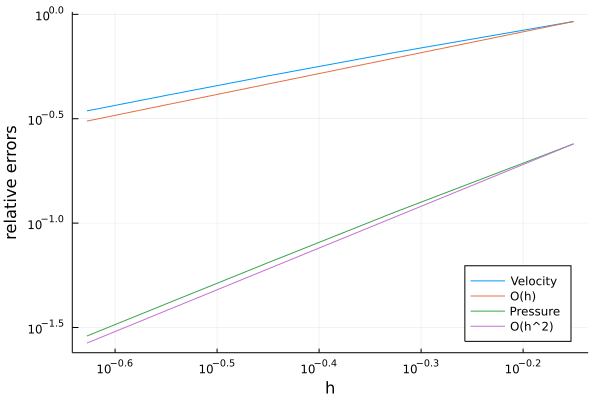

In [9]:
H2u = eu[1]*(H/H[1]).^1
H2p = ep[1]*(H/H[1]).^2
plot(H,[eu, H2u, ep, H2p], xaxis=:log, yaxis=:log, label = ["Velocity" "O(h)" "Pressure" "O(h^2)"], legend=:bottomright)
xlabel!("h")
ylabel!("relative errors")

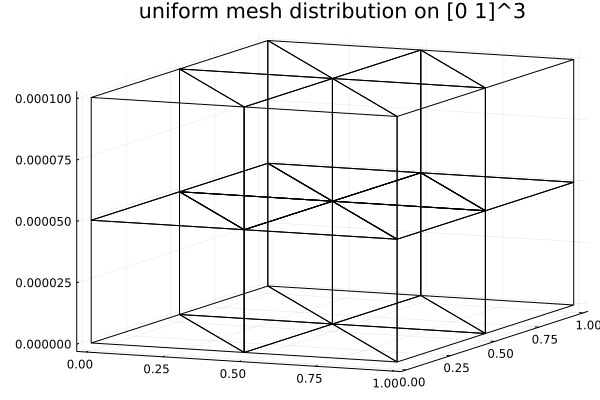

In [10]:
PlotMesh(2, 2, 2, a, b, c)

# Inf-Sup test
To get the inf-sup cosntant we need to solve (see eq (3.2) of Arnold and Marie 2009)

$$
<u,v>_V + b(v,p) + b(u,q) = -\lambda <p,q>_Q \quad \text{for all} \quad v,q \in V\times Q
$$
Then, the inf-sup constant, $\beta$ is
$$
\beta = \sqrt{\lambda_{min}}
$$

In [22]:
function GetLocalMat(coord_E, Q1d, Q_tri)
    
    w, q = GetQuadraturePrism(Q1d, Q_tri)
    qx = q[1,:]
    qy = q[2,:]
    qz = q[3,:]
    # total number of quadrature points, or m = length(qx)
    m = Q1d*Q_tri
    # return Nodal basis as (3,m,18) array
    Nhat = GetNodalBasis(coord_E, qx, qy, qz)
    # reshape Nhat as a (3m,18) array
    N = reshape(Nhat,3*m,:)
    # get (x,y,z) on E, detJ,...
    X, J, detJ = TrilinearMap(coord_E, qx, qy, qz)
    # weight, detJ
    W = zeros(3*m,3*m)
    for i=1:m
        W[3*i-2:3*i, 3*i-2:3*i]=I(3)*w[i]*detJ[i]
    end
    
    # Dhat and nodal basis for pressure are the same for all quadrature points
    Dhat = GetDivNodalBasis(coord_E)
    D = repeat(Dhat, inner=(m,1))
    Np = repeat([1], inner=(m,1))
    # create a diagonal matrix from weight and detJ
    w1 = w .* detJ
    WW = Diagonal(w1)
    
    
    # \int{u*v}
    u_v = N' * W * N
    # \int{div(u) * div(v)}
    div_u_v = D' * WW * D
    # <u,v>_V
    Se = u_v + div_u_v
    # <p,q>_Q
    Ce = Np' * WW * Np
    # b(u,q)
    Be = Np' * WW * D
    
    return Se, Be, Ce
end


function GetGlobalMat(Coord_Ns, LM, IENn, Q1d, Q_tri)
      
    num_elem = size(LM,2)
    global_dof = maximum(LM)
    S = zeros(global_dof, global_dof)
    B = zeros(num_elem, global_dof)
    C = zeros(num_elem, num_elem)

    for e=1:num_elem
        # get element restriction operator L for element e
        coord_E = GetCoordElem(Coord_Ns, IENn, e)
        L = GetElementRestriction(LM, coord_E, e)
        Se, Be, Ce = GetLocalMat(coord_E, Q1d, Q_tri)
        # assemble H
        S = S + L' * Se * L
        # assemble B
        B[e,:] = Be * L
        C[e,e] = Ce[1]
    end

    return S, B, C
end


function GetInfSupConst(S, B, C)
    """ This function solves
    <u,v>_V + b(v,p) + b(u,q) = -lamda<p,q>_Q
    where 
    beta = sqrt{lambda_min} is the inf-sup constant
    """

    Sinv = inv(S)
    LHS1 = B * Sinv * B'
    RHS1 = C
    D, V = eigvals(LHS1, RHS1)
    D = real(D)
    lambda1_min = minimum(D) 
    # inf-sup constant
    beta = sqrt(lambda1_min)

    return beta
end

GetInfSupConst (generic function with 1 method)

In [37]:
N = 6
beta = zeros(N-1)
hh = zeros(N-1)
# size of box [0,a]x[0,b]x[0,c]
a = 1
b = 1
c = 1
# quadrature
Q1d = 4
Q_tri = 19
# refinement to plot Inf-Sup
for i=1:N-1

    nx = i+1
    ny = i+1
    nz = i+1

    Coord_Ns = GetCoordNodes(nx, ny, nz, a, b, c)
    IENf, IENn = GetConnectivity(nx, ny, nz)
    ID = GetID(nx, ny, nz)
    LM = GetLM(ID, IENf)
    S, B, C = GetGlobalMat(Coord_Ns, LM, IENn, Q1d, Q_tri)
    bb = GetInfSupConst(S, B, C)
    beta[i] = bb
    
    # since mesh is uniform we compute diagonal of one element as h size
    coord_E = GetCoordElem(Coord_Ns, IENn,1)
    x2 = coord_E[2,1]
    y2 = coord_E[2,2]
    z2 = coord_E[2,3]
    x6 = coord_E[6,1]
    y6 = coord_E[6,2]
    z6 = coord_E[6,3]
    hh[i] = sqrt((x6-x2)^2 + (y6-y2)^2 + (z6-z2)^2)
end

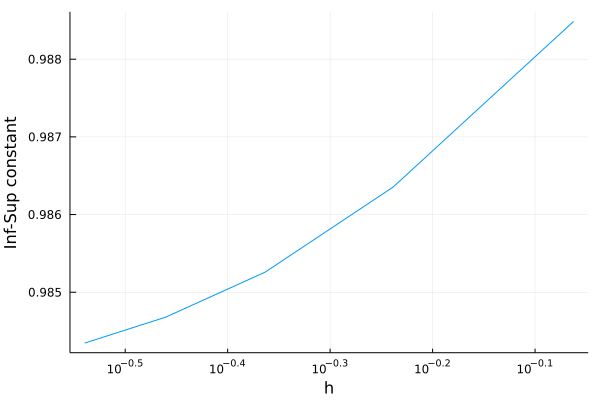

In [38]:
plot(hh, beta, xaxis=:log, legend=false)
xlabel!("h")
ylabel!("Inf-Sup constant")